In [1]:
import sys
sys.path.insert(0, '../model')

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from model import PMF

In [3]:
class EcommDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        assert self.X.shape[0] == self.y.shape[0]
        self.transform = transform
        pass
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.X[idx], self.y[idx])

In [4]:
def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

In [5]:
def training_epoch(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row, item_id_nums: col, ratings: val
        row = ele[0][:,0]
        col = ele[0][:,1]
        val = ele[1].squeeze()
         
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())
 
        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.item()
        
        print(f"Epoch {epoch}, batch_idx {batch_idx}, epoch_loss {loss.item()}", end='\r')
 
    epoch_loss /= len(train_data_loader.dataset)
    return epoch_loss

In [6]:
csv_path = '../dataset/sample_data.csv'
model_dir = '../trained'

In [7]:
reward_map = {'view': 1.0, 'cart': 2.0, 'purchase': 3.0}
ratio = 0.8
cuda = False
device = torch.device('cpu')
seed = 1
BATCH_SIZE = 1024
embedding_feature_size = 100
lr = 0.0001
weight_decay = 0.1
momentum = 0.9
epochs = 25

In [8]:
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)

kwargs = {'num_workers':2, 'pin_memory':True} if cuda else {}

In [9]:
data_df = pd.read_csv(csv_path)
data_df['behavior'] = data_df['event_type'].apply(lambda x : reward_map[x])

NUM_USERS, NUM_ITEMS = data_df.user_id_num.nunique(), data_df.product_id_num.nunique()

data = data_df.loc[:, ['user_id_num', 'product_id_num', 'behavior']]
# Shuffle data
data = shuffle(data, random_state=1)
data.reset_index(drop=True, inplace=True)
# Split data
train_data = data.loc[:int(ratio*data.shape[0])]
valid_data = data.loc[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data.loc[int((ratio+(1-ratio)/2)*data.shape[0]):]

In [10]:
X_train, y_train = train_data.loc[:, ['user_id_num', 'product_id_num']].values, train_data.loc[:, ['behavior']].values
X_valid, y_valid = valid_data.loc[:, ['user_id_num', 'product_id_num']].values, valid_data.loc[:, ['behavior']].values
X_test, y_test = test_data.loc[:, ['user_id_num', 'product_id_num']].values, test_data.loc[:, ['behavior']].values

In [11]:
train_dataset = EcommDataset(X_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

valid_dataset = EcommDataset(X_valid, y_valid)
vald_data_loader = DataLoader(valid_dataset, batch_size=len(X_valid), shuffle=False, **kwargs)
valid_data_full = next(iter(vald_data_loader))

test_dataset = EcommDataset(X_test, y_test)
test_data_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False, **kwargs)
test_data_full = next(iter(test_data_loader))

In [12]:
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=cuda)
if cuda:
    model.cuda()
    print("Model moved to CUDA")

loss_function = nn.MSELoss(reduction='sum')

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

print(f"total batches {len(train_data_loader)}")

total batches 99


In [13]:
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(ratio, BATCH_SIZE, epochs, weight_decay))
print(model)

for epoch in range(1, epochs+1):
    # Train epoch
    train_epoch_loss = training_epoch(epoch, train_data_loader)

    # Get epoch loss
    train_loss_list.append(train_epoch_loss)

    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(valid_data_full[0][:,0]).long().cuda()
        vali_col = Variable(valid_data_full[0][:,1]).long().cuda()
    else:
        vali_row = Variable(valid_data_full[0][:,0]).long()
        vali_col = Variable(valid_data_full[0][:,1]).long()

    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)

    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss)

    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), valid_data_full[1].cpu().data.numpy())
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), valid_data_full[1].data.numpy())

    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)

    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
            format(epoch, train_rmse, vali_rmse))

    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
        last_vali_rmse = vali_rmse

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:1024, epoches:25, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(5380, 100)
  (item_embeddings): Embedding(15286, 100)
  (ub): Embedding(5380, 1)
  (ib): Embedding(15286, 1)
)
Training epoch: 1, training rmse: 1.375266, vali rmse:1.366617
Training epoch: 2, training rmse: 1.080605, vali rmse:1.293068
Training epoch: 3, training rmse: 0.970746, vali rmse:1.255549
Training epoch: 4, training rmse: 0.905220, vali rmse:1.230492
Training epoch: 5, training rmse: 0.859574, vali rmse:1.211883
Training epoch: 6, training rmse: 0.825220, vali rmse:1.197303
Training epoch: 7, training rmse: 0.798156, vali rmse:1.185488
Training epoch: 8, training rmse: 0.776177, vali rmse:1.175676
Training epoch: 9, training rmse: 0.757930, vali rmse:1.167372
Training epoch: 10, training rmse: 0.742522, vali rmse:1.160237
Training epoch: 11, trainin

In [14]:
torch.save(model.state_dict(), os.path.join(model_dir, 'trained_pmf.pt'))

In [15]:
print('------------------------------------------- Testing Model------------------------------------------------')

# Move test set to CUDA
if cuda:
    test_row = Variable(test_data_full[0][:,0]).long().cuda()
    test_col = Variable(test_data_full[0][:,1]).long().cuda()
else:
    test_row = Variable(test_data_full[0][:,0]).long()
    test_col = Variable(test_data_full[0][:,1]).long()

------------------------------------------- Testing Model------------------------------------------------


In [16]:
# Get test predictions
preds = model.predict(test_row, test_col)

# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data_full[1].data.numpy())
else:
    test_rmse = RMSE(preds.data.numpy(), test_data_full[1].data.numpy())

print('Test rmse: {:f}'.format(test_rmse))

Test rmse: 1.097730


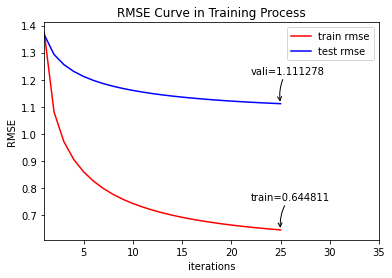

In [17]:
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
            xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
            xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.savefig("pmf-training-curve.png")
plt.show()